STEP 1: Generate the Orders Dataset

In [3]:
import pandas as pd
import numpy as np
!pip install faker
from faker import Faker
import random
from datetime import timedelta

fake = Faker()
np.random.seed(42)

regions = ['North', 'South', 'East', 'West']
statuses = ['Delivered', 'Late', 'In Transit', 'Cancelled']

def generate_order_data(n=1000):
    data = []
    for i in range(n):
        order_id = 1000 + i
        order_date = fake.date_between(start_date='-60d', end_date='-10d')
        ship_date = order_date + timedelta(days=random.randint(0, 2))
        delivery_date = ship_date + timedelta(days=random.randint(2, 5))
        region = random.choice(regions)
        status = random.choices(
            statuses, weights=(0.65, 0.15, 0.15, 0.05), k=1
        )[0]
        expected_delivery = ship_date + timedelta(days=3)
        delay_days = (delivery_date - expected_delivery).days
        delay_days = delay_days if delay_days > 0 else 0

        data.append([
            order_id, order_date, ship_date, delivery_date, region, status, delay_days
        ])

    df = pd.DataFrame(data, columns=[
        'order_id', 'order_date', 'ship_date', 'delivery_date',
        'region', 'status', 'delay_days'
    ])
    return df

orders_df = generate_order_data(1000)
orders_df.to_csv("orders.csv", index=False)
print(orders_df.head())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.5 MB/s eta 0:00:00
   order_id  order_date   ship_date delivery_date region      status  \
0      1000  2025-06-11  2025-06-13    2025-06-18   East   Delivered   
1      1001  2025-06-20  2025-06-21    2025-06-23   East  In Transit   
2      1002  2025-06-19  2025-06-19    2025-06-24   East        Late   
3      1003  2025-05-25  2025-05-27    2025-05-29   East  In Transit   
4      1004  2025-05-25  2025-05-27    2025-05-31   West   Delivered   

   delay_days  
0           2  
1           0  
2           2  
3           0  
4           1  


STEP 2: Generate the Inventory Dataset

In [4]:
def generate_inventory_data(n=100):
    product_ids = [f"P{1000+i}" for i in range(n)]
    data = []
    for pid in product_ids:
        region = random.choice(regions)
        stock_level = random.randint(50, 200)
        reorder_threshold = random.randint(60, 120)
        data.append([pid, region, stock_level, reorder_threshold])

    df = pd.DataFrame(data, columns=[
        'product_id', 'region', 'stock_level', 'reorder_threshold'
    ])
    return df

inventory_df = generate_inventory_data(100)
inventory_df.to_csv("inventory.csv", index=False)
print(inventory_df.head())


  product_id region  stock_level  reorder_threshold
0      P1000  South           58                 75
1      P1001  North           91                 71
2      P1002   East           50                 85
3      P1003   West          140                 81
4      P1004   West           63                 95


Using SQLite to analyse

In [5]:
import sqlite3

In [6]:
conn = sqlite3.connect("logistics.db")
cursor = conn.cursor()


In [7]:
orders_df = pd.read_csv("orders.csv")
inventory_df = pd.read_csv("inventory.csv")

orders_df.to_sql("orders", conn, if_exists="replace", index=False)
inventory_df.to_sql("inventory", conn, if_exists="replace", index=False)

100

Delivery delay performance by region

In [15]:
query = """
SELECT region,
       COUNT(*) AS total_orders,
       SUM(CASE WHEN status = 'Late' THEN 1 ELSE 0 END) AS late_orders,
       ROUND(AVG(delay_days), 2) AS avg_delay
FROM orders
WHERE status IN ('Delivered', 'Late')
GROUP BY region
ORDER BY late_orders DESC;
"""

delay_by_region_df = pd.read_sql_query(query, conn)
print(delay_by_region_df)


  region  total_orders  late_orders  avg_delay
0   East           203           43       0.73
1  South           207           40       0.70
2  North           203           39       0.75
3   West           192           33       0.79


In [16]:
delay_by_region_df.to_csv('delivery_delay_performance_by_region.csv', index=False)

Low Inventory Alert System

In [10]:
query = "PRAGMA table_info(inventory);"
schema_df = pd.read_sql_query(query, conn)
print(schema_df)


   cid               name     type  notnull dflt_value  pk
0    0         product_id     TEXT        0       None   0
1    1             region     TEXT        0       None   0
2    2        stock_level  INTEGER        0       None   0
3    3  reorder_threshold  INTEGER        0       None   0


In [11]:
query_low_inventory = """
SELECT
    product_id,
    region,
    stock_level,
    reorder_threshold
FROM inventory
WHERE stock_level < reorder_threshold
ORDER BY stock_level ASC;
"""

low_inventory_df = pd.read_sql_query(query_low_inventory, conn)
display(low_inventory_df)


,product_id,region,stock_level,reorder_threshold
0,P1002,East,50,85
1,P1060,East,50,116
2,P1056,North,51,116
3,P1068,South,51,112
4,P1084,West,53,92
5,P1040,West,55,115
6,P1051,West,55,85
7,P1076,East,57,94
8,P1099,North,57,82
9,P1000,South,58,75


In [17]:
# Export low inventory data
low_inventory_df.to_csv('low_inventory.csv', index=False)

Delivery Performance Over Time

In [12]:
query = "PRAGMA table_info(orders);"
orders_schema = pd.read_sql_query(query, conn)
print(orders_schema)


   cid           name     type  notnull dflt_value  pk
0    0       order_id  INTEGER        0       None   0
1    1     order_date     TEXT        0       None   0
2    2      ship_date     TEXT        0       None   0
3    3  delivery_date     TEXT        0       None   0
4    4         region     TEXT        0       None   0
5    5         status     TEXT        0       None   0
6    6     delay_days  INTEGER        0       None   0


In [13]:
query_ontime_performance = """
SELECT
    delivery_date,
    COUNT(*) AS total_deliveries,
    SUM(CASE WHEN delay_days = 0 THEN 1 ELSE 0 END) AS on_time_deliveries,
    ROUND(100.0 * SUM(CASE WHEN delay_days = 0 THEN 1 ELSE 0 END) / COUNT(*), 2) AS on_time_pct
FROM orders
WHERE status = 'Delivered'
GROUP BY delivery_date
ORDER BY delivery_date;
"""

ontime_df = pd.read_sql_query(query_ontime_performance, conn)

# Convert delivery_date to datetime for plotting
ontime_df['delivery_date'] = pd.to_datetime(ontime_df['delivery_date'])


/tmp/ipython-input-14-411159764.py:10: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


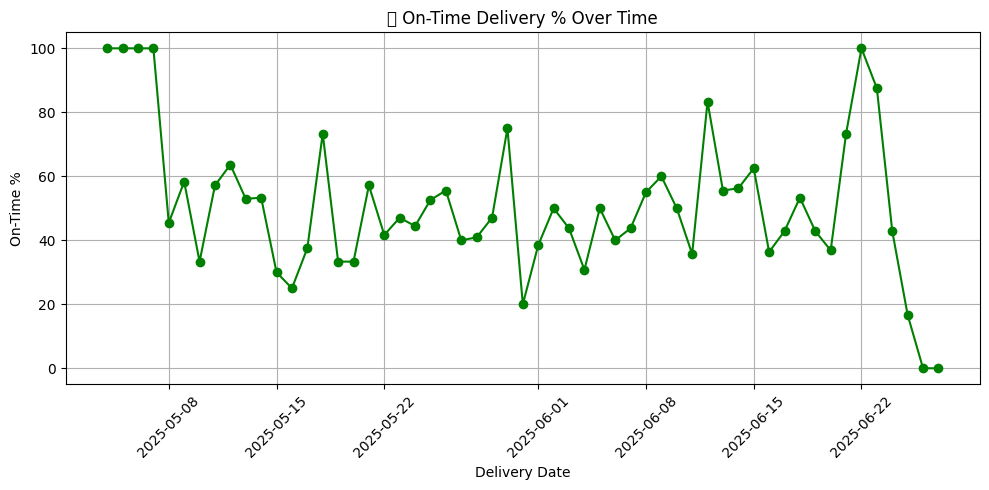

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(ontime_df['delivery_date'], ontime_df['on_time_pct'], marker='o', color='green')
plt.title("📦 On-Time Delivery % Over Time")
plt.xlabel("Delivery Date")
plt.ylabel("On-Time %")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Export on-time delivery performance data
ontime_df.to_csv('on_time_delivery_performance.csv', index=False)